# Haario ACMC: extensive testing on toy problems

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
from utils import (run_replicates, ecdf_norm_plotter)

import pints
import pints.toy
import pints.plot
from pints.functionaltests.haario_acmc import (test_haario_acmc_on_banana,
                                               test_haario_acmc_on_two_dim_gaussian,
                                               test_haario_acmc_on_correlated_gaussian)

# Two dimensional Gaussian

/home/chonlei/work/dev/pints-method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


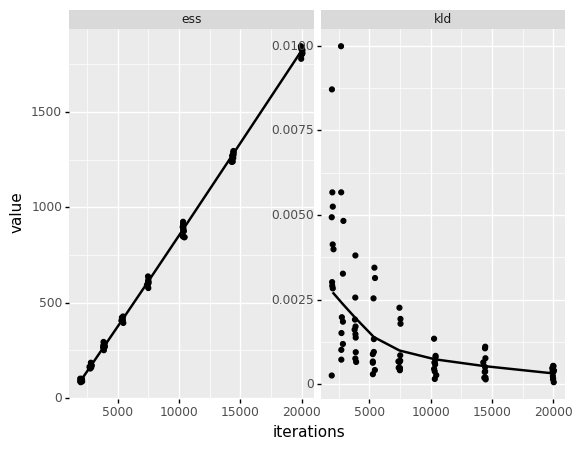

<ggplot: (8787331512179)>

In [6]:
low = np.log10(2000)
high = np.log10(20000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_haario_acmc_on_two_dim_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The ESS and KLD both trend in the correct directions.

Show example run results.

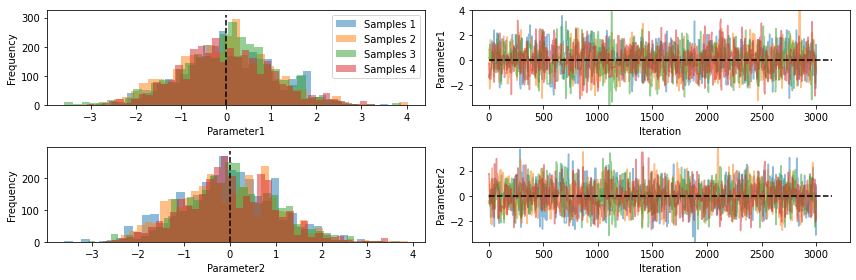

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  0.01    1.05    -2.02   -0.69  0.02   0.70   2.08     1.00    1036.05  511.36
param 2  -0.02   1.01    -1.96   -0.69  -0.02  0.70   1.99     1.00    1222.51  603.39


In [7]:
n_chains = 4
n_iterations = 4000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HaarioACMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

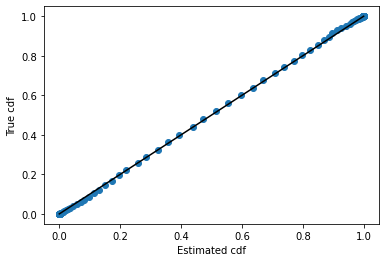

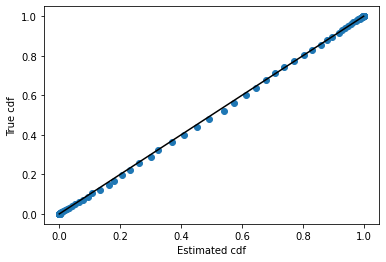

[None, None]

In [10]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

/home/chonlei/work/dev/pints-method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


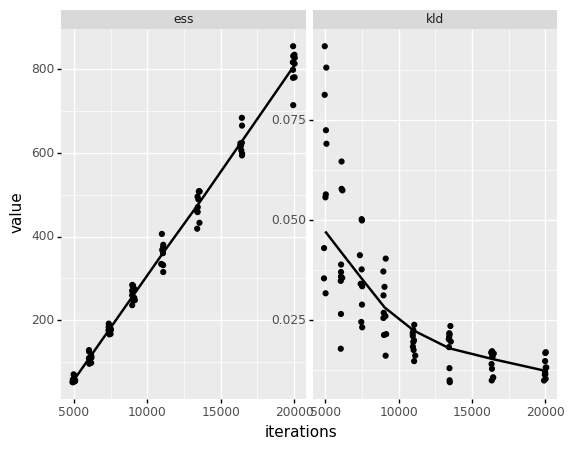

<ggplot: (8787329443467)>

In [11]:
low = np.log10(5000)
high = np.log10(20000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_haario_acmc_on_correlated_gaussian)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

Example run of results.

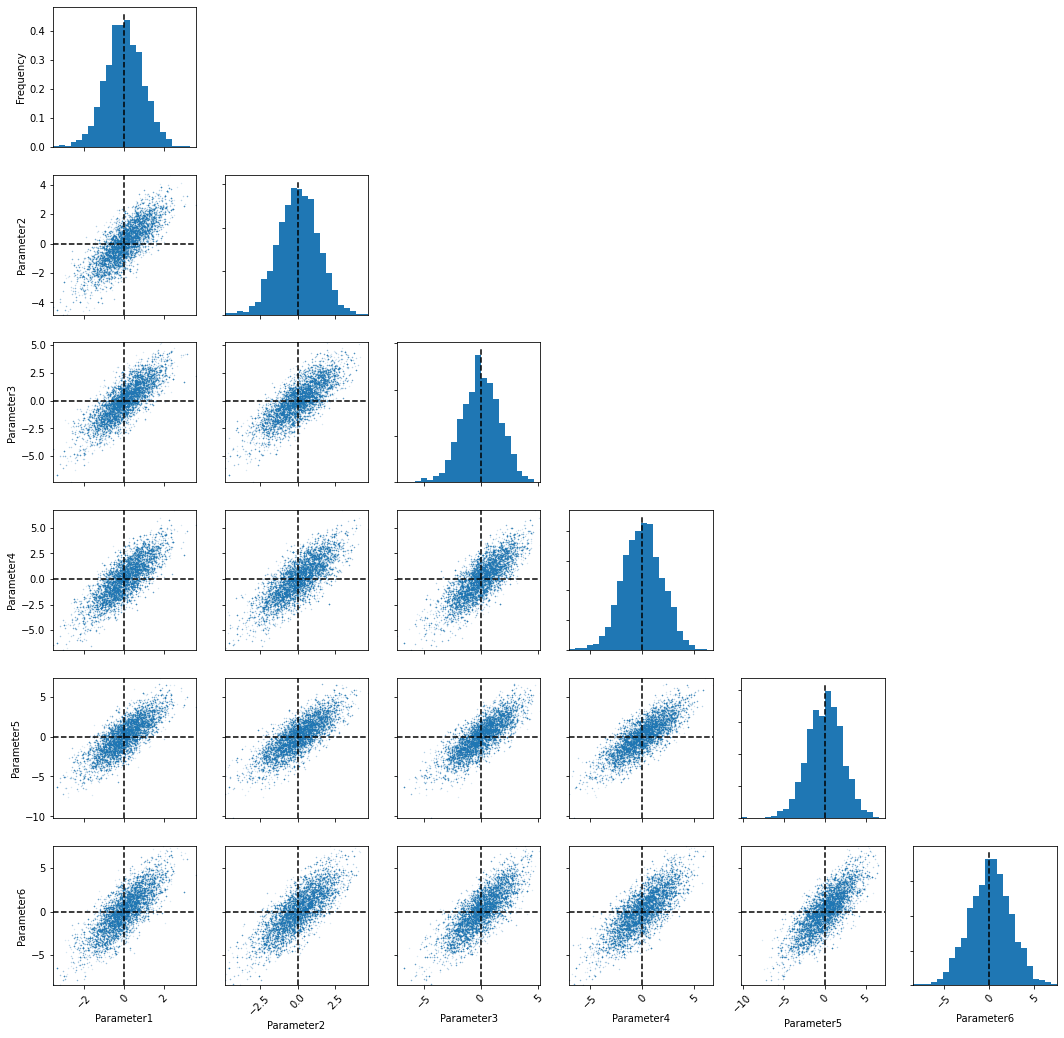

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  0.02    0.93    -1.86   -0.58  0.01   0.64   1.85     1.00    841.08  128.33
param 2  0.04    1.33    -2.56   -0.85  0.04   0.94   2.53     1.01    746.81  113.94
param 3  0.00    1.65    -3.20   -1.10  -0.02  1.11   3.10     1.01    755.72  115.30
param 4  0.02    1.87    -3.72   -1.26  0.02   1.28   3.53     1.01    709.13  108.20
param 5  0.04    2.10    -4.15   -1.40  0.15   1.47   4.07     1.01    882.86  134.70
param 6  0.10    2.31    -4.47   -1.43  0.14   1.65   4.49     1.01    799.28  121.95


In [12]:
n_chains = 4
n_iterations = 8000
n_warmup = 4000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HaarioACMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

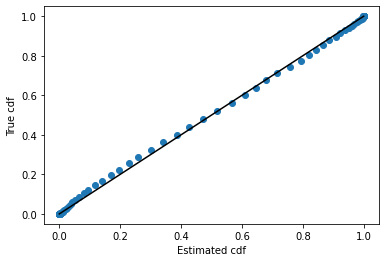

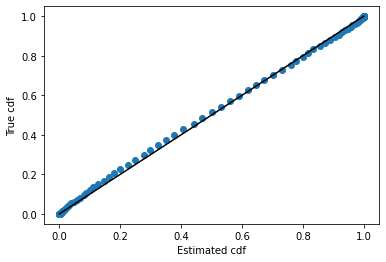

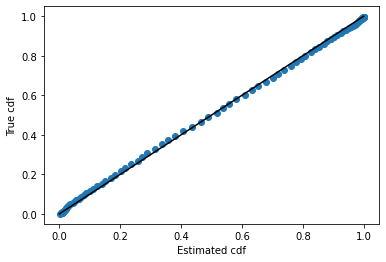

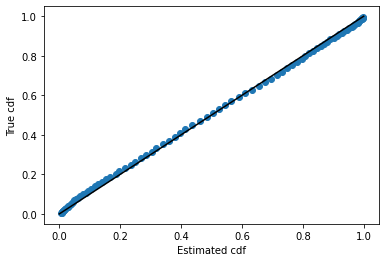

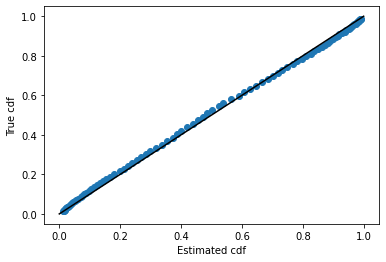

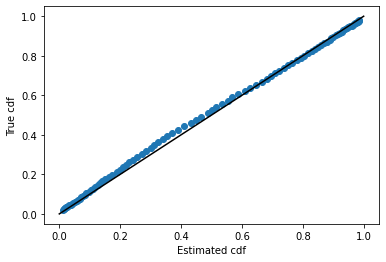

[None, None, None, None, None, None]

In [13]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Banana

/home/chonlei/work/dev/pints-method-merge-tests/venv/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


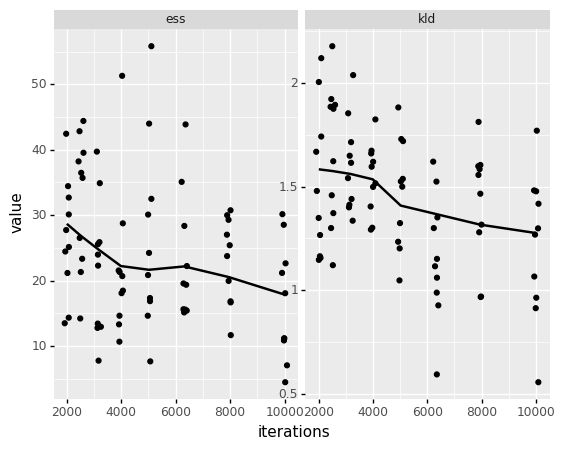

<ggplot: (8787322563371)>

In [14]:
low = np.log10(2000)
high = np.log10(10000)
test = run_replicates(10**np.linspace(low, high, 8), 10, test_haario_acmc_on_banana)

df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df,
        aes(x='iterations', y='value')) +
 geom_jitter(width=100) +
 geom_smooth(stat='smooth', se=False) +
 facet_wrap('variable', scales='free'))

The banana is a hard problem. Because of this, both the ESS and KLD do not behave well. It's likely that this is due to the problem being too hard for Haario-ACMC, rather than there being an issue with the method itself.

Example run of results.

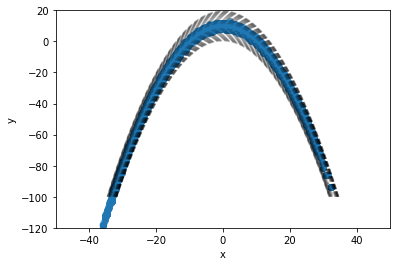

In [16]:
n_chains = 4
n_iterations = 10000
n_warmup = 4000

log_pdf = pints.toy.TwistedGaussianLogPDF(dimension=2, b=0.1)
log_prior = pints.MultivariateGaussianLogPrior([0, 0],
                                               [[10, 0], [0, 10]])
x0 = log_prior.sample(n_chains)
sigma0 = np.diag(np.array([1, 3]))

levels = np.linspace(-50, -1, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf([i, j]) for i in x] for j in y]

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.HaarioACMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

plt.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlim(-50, 50)
plt.ylim(-120, 20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()